<a href="https://colab.research.google.com/github/FlavioIBmec/Case-MMZR/blob/main/Case_MMZR_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Questão 2

In [1]:
# Importando todas as bibliotecas necessárias para manipulação de dados e visualização
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Lendo as bases de dados, a partir do github
df_local = pd.read_excel('https://raw.githubusercontent.com/FlavioIBmec/Case-MMZR/main/retornos_dados_locais.xlsx')
df_offshore = pd.read_excel('https://raw.githubusercontent.com/FlavioIBmec/Case-MMZR/main/retornos_dados_offshore.xlsx')

In [3]:
# --- Limpeza de df_local ---
# Remove as duas primeiras linhas do DataFrame, que contêm informações de cabeçalho redundantes
df_local = df_local.iloc[2:]
# Renomeia as colunas do DataFrame para nomes mais descritivos e padronizados
df_local = df_local.rename(columns={
'Unnamed: 0':'Data',
'Pós-Fixado':'CDI Pós-Fixado',
'Alternativos':'Alternativos - Dólar',
'RV Local':'RV Local - Ibovespa',
'Pré-Fixado':'Pré-Fixado - IDkA Pré 3 Anos',
'Imobiliário':'Imobiliário - IFIX',
'Retorno Absoluto':'Retorno Absoluto - IHFA',
'Inflação Tipo 1':'Inflação IMA-B',
'Inflação Tipo 2':'Inflação IMA-B 5',
'Inflação Tipo 3':'Inflação IMA-B 5+'
})


# --- Limpeza de df_offshore ---
# df_offshore também possui um cabeçalho multi-nível e nomes de ativos 'Retorno' duplicados.
# Remove as duas primeiras linhas do DataFrame, que contêm informações de cabeçalho redundantes
df_offshore = df_offshore.iloc[2:]
# Renomeia a primeira coluna para 'Data' para padronização
df_offshore = df_offshore.rename(columns={df_offshore.columns[0]: 'Data'})

# Converte a coluna 'Data' em ambos os DataFrames para o tipo datetime, facilitando operações baseadas em tempo
df_local['Data'] = pd.to_datetime(df_local['Data'])
df_offshore['Data'] = pd.to_datetime(df_offshore['Data'])

In [4]:
# Realizando o merge das duas bases em uma só chamada 'df'
df = pd.merge(df_local, df_offshore, on='Data', how='inner')

In [5]:
# Define um dicionário com os pesos de cada ativo na carteira de investimentos
carteira = {"CDI Pós-Fixado":0.315,"Alternativos - Dólar":0.02,"Imobiliário - IFIX":0.05,"RV Global":0.075,
            "RV Local - Ibovespa":0.05,"RF Global":0.1,"Retorno Absoluto - IHFA":0.165,
            "Inflação IMA-B":0.225,"Inflação IMA-B 5":0.225,"Inflação IMA-B 5+":0.225}

# Converter o dicionário 'carteira' para uma Série do Pandas para permitir a multiplicação com 'df.sum()'
weights_series = pd.Series(carteira)

In [6]:
# Define uma lista de ativos considerados 'fixos' na composição da carteira
ativos_fixos = ["CDI Pós-Fixado", "Alternativos - Dólar", "RV Local - Ibovespa", "Imobiliário - IFIX",
                "Retorno Absoluto - IHFA", "RV Global", "RF Global"]
# Define uma lista de ativos considerados 'variáveis', sendo que um deles será selecionado por carteira (neste caso, diferentes tipos de inflação)
ativos_variaveis = ["Inflação IMA-B", "Inflação IMA-B 5", "Inflação IMA-B 5+"]  # um por carteira

In [7]:
# Define uma função para calcular os retornos dos portfólios com base nos ativos fixos e um ativo variável
def calcula_portfolios(df, weights, ativos_fixos, ativos_variaveis):
    portfolios = {} # Dicionário para armazenar os retornos diários de cada portfólio

    for ativo in ativos_variaveis:
        ativos = ativos_fixos + [ativo]
        # Calcula o retorno diário do portfólio, multiplicando os retornos dos ativos pelos seus respectivos pesos
        portfolios[ativo] = df[ativos] @ weights[ativos]

    return portfolios

# Chama a função para calcular os retornos diários dos portfólios, usando o DataFrame principal e os pesos definidos
portfolios = calcula_portfolios(df,weights_series,ativos_fixos,ativos_variaveis)

In [8]:
def semidesvio(retorno):
    # Filtra apenas os retornos negativos
    retorno_negativo = retorno[retorno < 0]
    # Se não houver retornos negativos, o semidesvio é 0
    if retorno_negativo.empty:
        return 0.0
    # Retorna o desvio padrão dos retornos negativos
    return retorno_negativo.std()

In [9]:
def max_drawdown(retorno):
    # Calcula o capital acumulado ao longo do tempo
    retorno_cumulativo = (1 + retorno).cumprod()

    # Encontra os picos (máximos cumulativos) da série de capital
    pico = retorno_cumulativo.cummax()

    # Calcula o drawdown para cada período como a porcentagem de queda em relação ao pico anterior
    drawdown = (retorno_cumulativo - pico) / pico

    # Encontra o drawdown máximo (o valor mais negativo)
    max_dd = drawdown.min()

    # Retorna o valor absoluto do drawdown máximo
    return abs(max_dd)

In [10]:
def var_parametrico_95(retorno):
    # Calcula a média dos retornos
    media = retorno.mean()
    # Calcula o desvio padrão dos retornos
    std_dev = retorno.std()
    # Calcula o VaR paramétrico usando a média, desvio padrão e o z-score para 5% na cauda inferior (95% de confiança)
    var = media + norm.ppf(0.05) * std_dev
    # Retorna o valor absoluto do VaR
    return abs(var)

In [11]:
def var_historico_95(retorno):
    # Calcula o 5º percentil dos retornos para 95% de confiança
    var = retorno.quantile(0.05)
    # Retorna o valor absoluto do VaR
    return abs(var)

In [12]:
def expected_shortfall_95(retorno):
    # Calcula o VaR histórico de 95% como ponto de corte
    var = retorno.quantile(0.05)
    # Seleciona os retornos que são menores que o VaR (ou seja, as perdas mais extremas)
    shortfall_returns = retorno[retorno < var]
    # Calcula a média desses retornos para obter o Expected Shortfall
    es = shortfall_returns.mean()
    # Retorna o valor absoluto do Expected Shortfall
    return abs(es)

Questão 2-A)

In [13]:
# Dicionário para armazenar os resultados das métricas de risco para cada portfólio
metricas_risco = {}

# Itera sobre cada portfólio para calcular suas métricas de risco
for nome, retorno in portfolios.items():
  metricas_risco[nome] = {
    "Semidesvio": semidesvio(retorno),
    "Max Drawdown": max_drawdown(retorno),
    "VaR Paramétrico 95": var_parametrico_95(retorno),
    "VaR Histórico 95": var_historico_95(retorno),
    "Expected Shortfall 95": expected_shortfall_95(retorno)
  }


# Converte o dicionário de resultados em um DataFrame do Pandas, transpondo para que os portfólios sejam os índices
df_risco = pd.DataFrame(metricas_risco).T

print("Métricas de Risco para Cada Portfólio:")
display(df_risco)

Métricas de Risco para Cada Portfólio:


,Semidesvio,Max Drawdown,VaR Paramétrico 95,VaR Histórico 95,Expected Shortfall 95
Inflação IMA-B,0.002010,0.104136,0.003234,0.002426,0.004591
Inflação IMA-B 5,0.001693,0.088560,0.002801,0.002281,0.004049
Inflação IMA-B 5+,0.002296,0.117528,0.003735,0.002812,0.005211


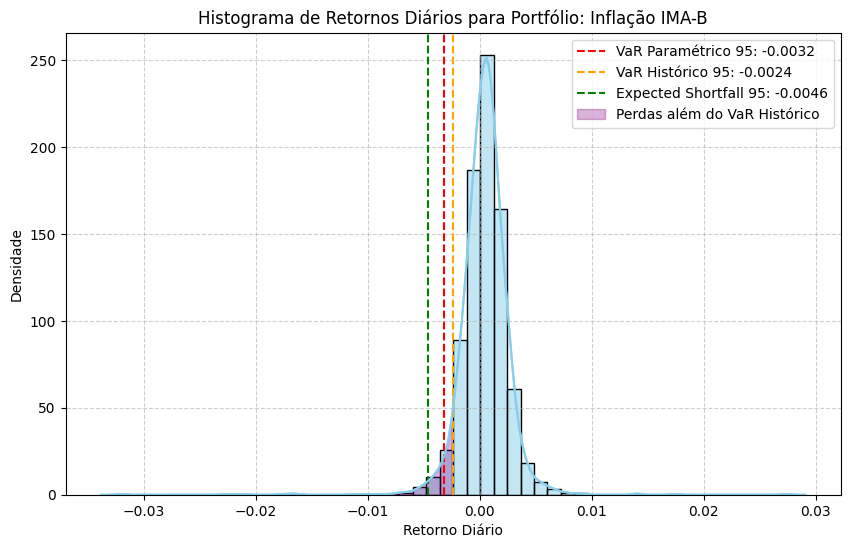

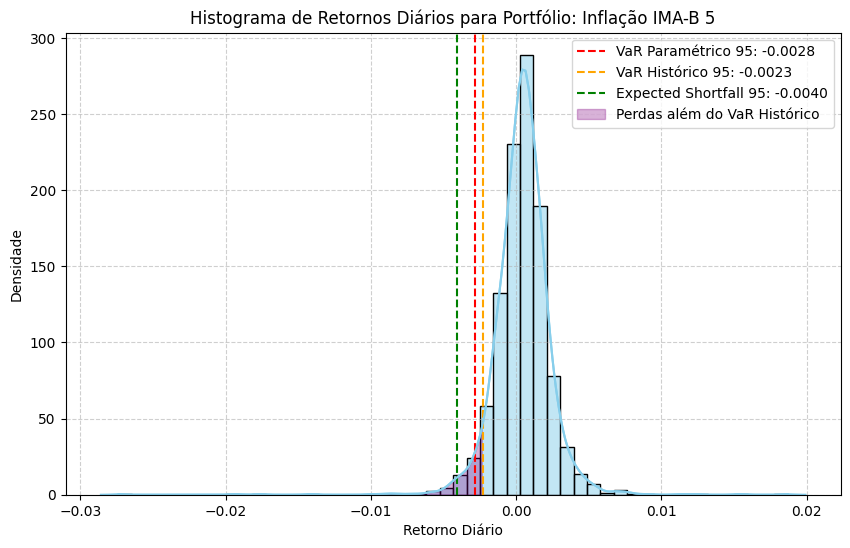

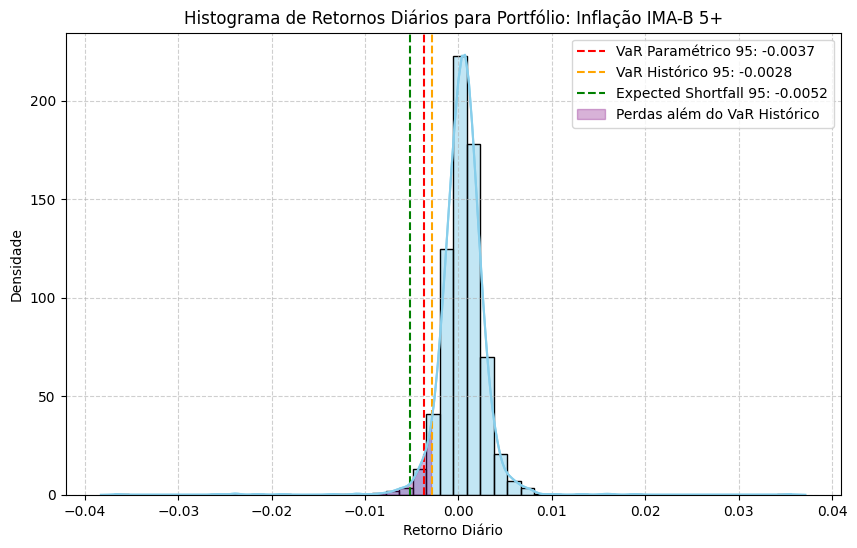

In [14]:
# Itera sobre cada portfólio para gerar um histograma de retornos com as métricas de risco
for nome, retorno in portfolios.items():

    # Obtém as métricas de risco para o portfólio atual
    # Os valores de VaR e ES são negados para serem plotados no lado esquerdo (perdas) do histograma
    var_param = -df_risco.loc[nome, 'VaR Paramétrico 95']
    var_hist  = -df_risco.loc[nome, 'VaR Histórico 95']
    es        = -df_risco.loc[nome, 'Expected Shortfall 95']

    # Cria uma nova figura para cada histograma
    plt.figure(figsize=(10, 6))
    # Plota o histograma dos retornos diários com estimativa de densidade de kernel (kde)
    sns.histplot(retorno, bins=50, kde=True, color='skyblue', stat='density')
    # Adiciona linhas verticais para VaR Paramétrico, VaR Histórico e Expected Shortfall
    plt.axvline(var_param, color='red', linestyle='--', label=f'VaR Paramétrico 95: {var_param:.4f}')
    plt.axvline(var_hist, color='orange', linestyle='--', label=f'VaR Histórico 95: {var_hist:.4f}')
    plt.axvline(es, color='green', linestyle='--', label=f'Expected Shortfall 95: {es:.4f}')

    # Sombra a área à esquerda do VaR Histórico (representando perdas além do VaR)
    # Obtém os valores de densidade do plot KDE para sombrear corretamente
    kde = sns.kdeplot(retorno, color='skyblue', legend=False).get_lines()[0].get_data()
    x_kde, y_kde = kde[0], kde[1]

    # Encontra os índices onde x_kde é menor ou igual ao VaR Histórico
    fill_indices = x_kde <= var_hist
    x_fill = x_kde[fill_indices]
    y_fill = y_kde[fill_indices]

    # Preenche a área sob a curva de densidade
    plt.fill_between(x_fill, 0, y_fill, color='purple', alpha=0.3, label='Perdas além do VaR Histórico')


    # Define o título e os rótulos dos eixos do gráfico
    plt.title(f'Histograma de Retornos Diários para Portfólio: {nome}')
    plt.xlabel('Retorno Diário')
    plt.ylabel('Densidade')
    # Exibe a legenda
    plt.legend()
    # Adiciona uma grade ao gráfico para melhor legibilidade
    plt.grid(True, linestyle='--', alpha=0.6)
    # Exibe o gráfico
    plt.show()

# Segunda parte da Q2

Q: Escreva em suas palavras quais seriam as vantagens e desvantagens de se usar o VaR Paramétrico ou o histórico e em quais cenários/contexto seria vantajoso escolher cada uma.

R: O VaR paramétrico e o VaR histórico são métodos de mensuração de risco com abordagens diferentes. O VaR paramétrico é simples e rápido, pois assume uma distribuição teórica para os retornos, geralmente a normal, funcionando melhor em períodos de estabilidade, mas podendo subestimar perdas extremas. O VaR histórico, por sua vez, não faz suposições sobre a distribuição e utiliza apenas dados observados no passado, captando melhor assimetrias e caudas, embora dependa fortemente da amostra escolhida. Assim, o paramétrico é mais adequado para análises rápidas e rotineiras, enquanto o histórico é mais indicado quando se deseja uma medida baseada no comportamento real dos dados.

Q: Explique em suas palavras o que é o semidesvio e qual a vantagem de usar ele em análises de risco.

R: O semidesvio é uma medida de risco que considera somente os desvios negativos dos retornos em relação à média ou a um alvo, ignorando variações positivas. Sua vantagem é focar apenas no risco de perda, tornando a análise mais alinhada ao que preocupa o investidor.

Q: Explique em suas palavras o que seria o Expected Shortfall e sua vantagem de usar essa métrica em análise de risco.

R: O Expected Shortfall é a perda média esperada nos piores casos, isto é, a média das perdas que ocorrem quando o VaR é ultrapassado. Sua principal vantagem é capturar a gravidade das perdas extremas, sendo mais informativo e conservador do que o VaR.

Q: Explique em suas palavras a diferença, na linguagem Python, entre um módulo, uma biblioteca e um pacote.

R: Em Python, um módulo é um arquivo que contém código reutilizável,ex - import math, um pacote é um conjunto organizado de módulos dentro de uma pasta, ex - numpy.linalg, e uma biblioteca é um termo mais amplo que se refere a um conjunto de pacotes e módulos voltados para um determinado propósito, ex - pandas, numpy.